# Minimal code for a single F layer solution using our tooling

Here we calculate everything but avoid the outer self consistent loop

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model

In [47]:
# Flayer setup
f_layer_thickness = 200_000 # m
delta_t_icb = 50 # K below projected adiabat
xfe_outer_core = 0.95 # mol frac Fe
xfe_icb = 0.94 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False
opt_mode='both'

In [48]:
# Setup the f-layer

# Derived radii
r_flayer_top = r_icb + f_layer_thickness
        
# Discretisation points
nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

temperature_function, adiabatic_temperature_function, flayer_temperature_function, t_func_creator, composition_function, \
        pressure_function, gravity_function, x_func_creator = flayer.setup_flayer_functions(r_icb, r_cmb, f_layer_thickness, 
                                                      gruneisen_parameter, delta_t_icb, xfe_outer_core, xfe_icb, knott_radii)

In [61]:
rs = np.linspace(r_icb, r_flayer_top+100.0E3)

# Check PREM works ... and print some interesting values
prem = earth_model.Prem()
print("Pressure at ICB:", prem.pressure(r_icb/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(r_flayer_top/1000.0), "GPa")
print("g at ICB:", prem.gravity(r_icb/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(r_flayer_top/1000.0), "m/s**2")

# Find the liquidus
tl = feot.find_liquidus(composition_function(rs), pressure_function(rs))

# Find the liquid density

liquid_density, _, _, _, _, _ = feot.densities(composition_function(rs), pressure_function(rs), temperature_function(rs))
# Should this have the well mixed composition?
adiabatic_liquid_density, _, _, _, _, _ = feot.densities(composition_function(rs), pressure_function(rs), adiabatic_temperature_function(rs))

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


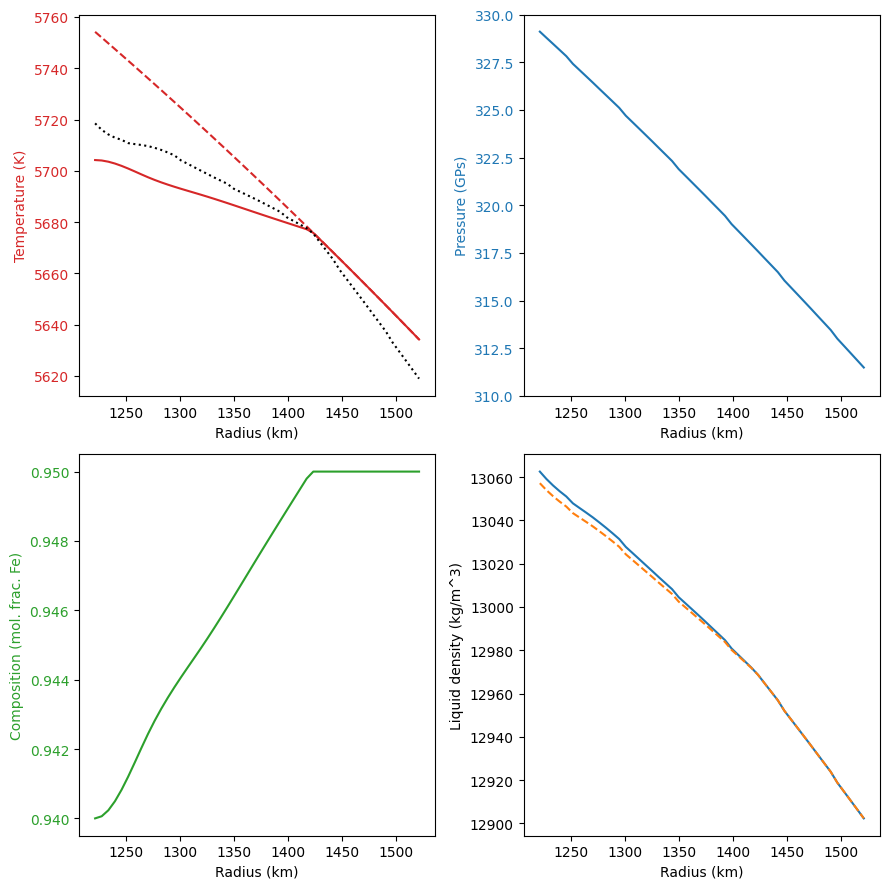

In [62]:

# Plot the F-layer setup alongside the liquidus
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(9,9), tight_layout=True)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, temperature_function(rs), color=color)
ax1.plot(rs/1000.0, adiabatic_temperature_function(rs), color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])
 

color = 'tab:blue'
ax2.set_xlabel('Radius (km)')
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, pressure_function(rs), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([310, 330])

color = 'tab:green'
ax3.set_xlabel('Radius (km)')
ax3.set_ylabel('Composition (mol. frac. Fe)', color=color)  
ax3.plot(rs/1000.0, composition_function(rs), color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4.set_xlabel('Radius (km)')
ax4.set_ylabel('Liquid density (kg/m^3)')  
ax4.plot(rs/1000.0, liquid_density)
ax4.plot(rs/1000.0, adiabatic_liquid_density, ls='--')
ax4.tick_params(axis='y')

fig.tight_layout()  
plt.show()